# DQN

## Setup

### Initialization

In [1]:
from pathlib import Path
import os

import ipdb

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import pandas as pd
import seaborn as sns
from imojify import imojify

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# from torchinfo import summary

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
from utils import Params, random_choice
from environment_tensor import WrappedEnvironment, Actions, CONTEXTS_LABELS, Cues
from agent_tensor import EpsilonGreedy
import plotting

In [4]:
# Formatting & autoreload stuff
%load_ext lab_black
%load_ext autoreload
%autoreload 2
# %matplotlib ipympl

In [5]:
sns.set_theme(font_scale=1.5)
mpl.rcParams["font.family"] = ["sans-serif"]
mpl.rcParams["font.sans-serif"] = [
    "Fira Sans",
    "Computer Modern Sans Serif",
    "DejaVu Sans",
    "Verdana",
    "Arial",
    "Helvetica",
]
# plt.style.use("ggplot")

In [6]:
ROOT_PATH = Path("env").parent
PLOTS_PATH = ROOT_PATH / "plots"
print(f"Plots path: `{PLOTS_PATH.absolute()}`")

Plots path: `/home/kir0ul/Projects/RL_Olfaction/TriangleTask/plots`


In [7]:
def check_plots():
    if not PLOTS_PATH.exists():
        os.mkdir(PLOTS_PATH)

### Parameters

In [8]:
p = Params(
    seed=42,
    n_runs=1,
    total_episodes=600,
    # epsilon=0.2,
    alpha=0.001,
    gamma=0.9,
    nHiddenUnits=(5 * 5 + 2) * 2,
    replay_buffer_max_size=1000,
    epsilon_min=0.1,
    epsilon_max=1.0,
    decay_rate=0.01,
    epsilon_warmup=100,
)
p

Params(seed=42, rng=None, n_runs=1, total_episodes=600, epsilon=0.2, epsilon_min=0.1, epsilon_max=1.0, decay_rate=0.01, epsilon_warmup=100, gamma=0.9, alpha=0.001, nLayers=5, nHiddenUnits=54, n_observations=None, n_actions=None, replay_buffer_max_size=1000)

In [9]:
# # Set the seed
# p.rng = np.random.default_rng(p.seed)

### Environment definition

In [10]:
# Load the environment
env = WrappedEnvironment(one_hot_state=True)

In [11]:
# Get number of actions
# n_actions = env.action_space.n
p.n_actions = env.numActions

# Get the number of state observations
# state, info = env.reset()
state = env.reset()
p.n_observations = len(state)

print(f"Number of actions: {p.n_actions}")
print(f"Number of observations: {p.n_observations}")

Number of actions: 4
Number of observations: 28


### Network definition

In [12]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions, n_units=16):
        super(DQN, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(n_observations, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_actions),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.mlp(x)

In [13]:
if env.one_hot_state:
    net = DQN(
        n_observations=p.n_observations,
        n_actions=p.n_actions,
        n_units=3 * p.n_observations,
    ).to(device)
else:
    net = DQN(
        n_observations=p.n_observations,
        n_actions=p.n_actions,
        n_units=p.nHiddenUnits,
    ).to(device)
net

DQN(
  (mlp): Sequential(
    (0): Linear(in_features=28, out_features=84, bias=True)
    (1): ReLU()
    (2): Linear(in_features=84, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=84, bias=True)
    (5): ReLU()
    (6): Linear(in_features=84, out_features=4, bias=True)
    (7): ReLU()
  )
)

In [14]:
# print("Model parameters:")
# print(list(net.parameters()))
print("\n\nParameters sizes summary:")
print([item.shape for item in net.parameters()])



Parameters sizes summary:
[torch.Size([84, 28]), torch.Size([84]), torch.Size([84, 84]), torch.Size([84]), torch.Size([84, 84]), torch.Size([84]), torch.Size([4, 84]), torch.Size([4])]


In [15]:
# summary(net, input_size=[state.shape], verbose=0)

### Optimizer

In [16]:
optimizer = optim.AdamW(net.parameters(), lr=p.alpha, amsgrad=True)
optimizer

AdamW (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)

### Explorer

In [17]:
# class EpsilonGreedy:
#     def __init__(
#         self,
#         epsilon,
#         epsilon_min=0.1,
#         epsilon_max=1.0,
#         decay_rate=0.05,
#         epsilon_warmup=25,
#         rng=None,
#     ):
#         self.epsilon = epsilon
#         self.epsilon_min = epsilon_min
#         self.epsilon_max = epsilon_max
#         self.decay_rate = decay_rate
#         self.epsilon_warmup = epsilon_warmup
#         if rng:
#             self.rng = rng

#     def choose_action(self, action_space, state, state_action_values):
#         """Choose an action a in the current world state (s)"""

#         def sample(action_space):
#             return random_choice(action_space)

#         # # First we randomize a number
#         # if hasattr(self, "rng"):
#         #     explor_exploit_tradeoff = self.rng.uniform(0, 1)
#         # else:
#         #     explor_exploit_tradeoff = np.random.uniform(0, 1)
#         explor_exploit_tradeoff = torch.rand(1)

#         # Exploration
#         if explor_exploit_tradeoff.item() < self.epsilon:
#             # action = action_space.sample()
#             action = sample(action_space)

#         # Exploitation (taking the biggest Q-value for this state)
#         else:
#             # Break ties randomly
#             # If all actions are the same for this state we choose a random one
#             # (otherwise `argmax()` would always take the first one)
#             if torch.all(state_action_values == state_action_values[0]):
#                 action = sample(action_space)
#             else:
#                 action = torch.argmax(state_action_values)
#         return action

#     def update_epsilon(self, ep):
#         if ep > self.epsilon_warmup:
#             """Reduce epsilon (because we need less and less exploration)"""
#             epsilon = (
#                 self.epsilon_min
#                 + (self.epsilon_max - self.epsilon_min)
#                 * torch.exp(-self.decay_rate * (ep - self.epsilon_warmup)).item()
#             )
#         else:
#             epsilon = self.epsilon
#         return epsilon

In [18]:
explorer = EpsilonGreedy(
    epsilon=p.epsilon_max,
    epsilon_min=p.epsilon_min,
    epsilon_max=p.epsilon_max,
    decay_rate=p.decay_rate,
    epsilon_warmup=p.epsilon_warmup,
)
episodes = torch.arange(p.total_episodes, device=device)
epsilons = torch.empty_like(episodes) * torch.nan
for eps_i, epsi in enumerate(epsilons):
    epsilons[eps_i] = explorer.epsilon
    explorer.epsilon = explorer.update_epsilon(episodes[eps_i])

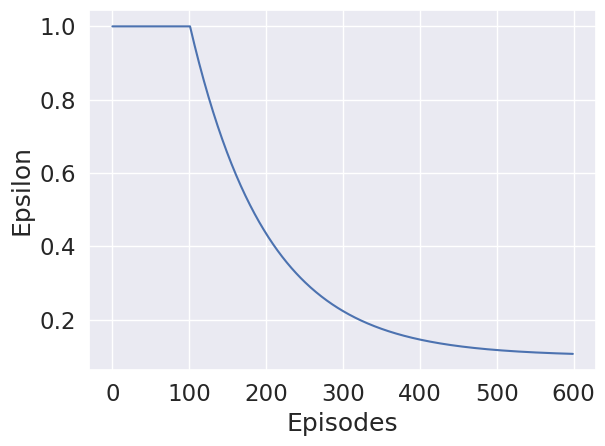

In [19]:
fig, ax = plt.subplots()
sns.lineplot(epsilons)
ax.set(ylabel="Epsilon")
ax.set(xlabel="Episodes")
fig.tight_layout()
plt.show()

In [20]:
explorer = EpsilonGreedy(
    epsilon=p.epsilon_max,
    epsilon_min=p.epsilon_min,
    epsilon_max=p.epsilon_max,
    decay_rate=p.decay_rate,
    epsilon_warmup=p.epsilon_warmup,
)

In [21]:
def collect_weights_biases(net):
    biases = {"val": [], "grad": []}
    weights = {"val": [], "grad": []}
    for layer in net.mlp.children():
        layer_params = layer.parameters()
        for idx, subparams in enumerate(layer_params):
            if idx > 2:
                raise ValueError(
                    "There should be max 2 sets of parameters: weights and biases"
                )
            if len(subparams.shape) > 2:
                raise ValueError("The weights have more dimensions than expected")

            if len(subparams.shape) == 1:
                biases["val"].append(subparams)
                biases["grad"].append(subparams.grad)
            elif len(subparams.shape) == 2:
                weights["val"].append(subparams)
                weights["grad"].append(subparams.grad)
    return weights, biases

In [22]:
def params_df_stats(weights, key, current_df=None):
    if not current_df is None:
        last_idx = current_df.index[-1] + 1
        df = current_df
    else:
        last_idx = 0
        df = None

    for idx, val in enumerate(weights[key]):
        tmp_df = pd.DataFrame(
            data={
                "Std": val.detach().cpu().std().item(),
                "Avg": val.detach().cpu().mean().item(),
                "Layer": idx,
                "Index": [last_idx + idx],
            },
            index=[last_idx + idx],
        )

        if df is None:
            df = tmp_df
        else:
            df = pd.concat((df, tmp_df))
    return df

## Main loop

In [23]:
rewards = torch.zeros((p.total_episodes, p.n_runs), device=device)
steps = torch.zeros((p.total_episodes, p.n_runs), device=device)
episodes = torch.arange(p.total_episodes, device=device)
all_states = []
all_actions = []
losses = [[] for _ in range(p.n_runs)]

for run in range(p.n_runs):  # Run several times to account for stochasticity
    # # Reset model
    # net = DQN(
    #     n_observations=p.n_observations, n_actions=p.n_actions, n_units=p.nHiddenUnits
    # ).to(device)
    # optimizer = optim.AdamW(net.parameters(), lr=p.alpha, amsgrad=True)
    weights_val_stats = None
    biases_val_stats = None
    weights_grad_stats = None
    biases_grad_stats = None
    replay_buffer = []

    for episode in tqdm(
        episodes, desc=f"Run {run+1}/{p.n_runs} - Episodes", leave=False
    ):
        state = env.reset()  # Reset the environment
        state = state.clone().float().detach().to(device)
        step_count = 0
        done = False
        total_rewards = 0

        while not done:
            state_action_values = net(state).to(device)  # Q(s_t)
            action = explorer.choose_action(
                action_space=env.action_space,
                state=state,
                state_action_values=state_action_values,
            )

            # Record states and actions
            all_states.append(state)
            all_actions.append(Actions(action.item()).name)

            next_state, reward, done = env.step(
                action=action.item(), current_state=state
            )

            # Store transition in replay buffer
            if len(replay_buffer) >= p.replay_buffer_max_size:
                replay_buffer = replay_buffer[1:]
            # [current_state (2 or 28 x1), action (1x1), next_state (2 or 28 x1), reward (1x1), done (1x1 bool)]
            replay_buffer.append([state, action, reward, next_state, done])
            (
                state_sampled,
                action_sampled,
                reward_sampled,
                next_state_sampled,
                done_sampled,
            ) = random_choice(replay_buffer, length=len(replay_buffer))

            # See DQN paper for equations: https://doi.org/10.1038/nature14236
            state_action_values_sampled = net(state_sampled).to(device)  # Q(s_t)
            state_action_value = state_action_values_sampled[action_sampled].unsqueeze(
                -1
            )  # Q(s_t, a)
            if done_sampled:
                expected_state_action_value = reward_sampled
            else:
                with torch.no_grad():
                    next_state_values = (
                        net(next_state_sampled).to(device).max().unsqueeze(-1)
                    )  # Q(s_t+1, a)
                expected_state_action_value = (
                    reward_sampled + p.gamma * next_state_values
                )  # y_j (Bellman optimality equation)

            # Compute loss
            criterion = nn.MSELoss()
            loss = criterion(
                input=state_action_value, target=expected_state_action_value
            )  # TD update

            # Optimize the model
            optimizer.zero_grad()
            loss.backward()

            # In-place gradient clipping
            torch.nn.utils.clip_grad_value_(net.parameters(), 100)
            optimizer.step()

            total_rewards += reward
            step_count += 1
            losses[run].append(loss.item())

            # Move to the next state
            state = next_state

        explorer.epsilon = explorer.update_epsilon(episode)

        rewards[episode, run] = total_rewards
        steps[episode, run] = step_count
        weights, biases = collect_weights_biases(net=net)
        weights_val_stats = params_df_stats(
            weights, key="val", current_df=weights_grad_stats
        )
        biases_val_stats = params_df_stats(
            biases, key="val", current_df=biases_val_stats
        )
        biases_grad_stats = params_df_stats(
            biases, key="grad", current_df=biases_grad_stats
        )
        weights_grad_stats = params_df_stats(
            weights, key="grad", current_df=weights_val_stats
        )
    weights_val_stats.set_index("Index", inplace=True)
    biases_val_stats.set_index("Index", inplace=True)
    biases_grad_stats.set_index("Index", inplace=True)
    weights_grad_stats.set_index("Index", inplace=True)

## Visualization

### States & actions distributions

In [24]:
def postprocess(episodes, p, rewards, steps):
    """Convert the results of the simulation in dataframes."""
    res = pd.DataFrame(
        data={
            "Episodes": episodes.tile(p.n_runs).cpu(),
            "Rewards": rewards.T.flatten().cpu(),
            "Steps": steps.T.flatten().cpu(),
        }
    )
    # res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    return res

In [25]:
res = postprocess(episodes, p, rewards, steps)
res

,Episodes,Rewards,Steps
0,0,10.0,158.0
1,1,0.0,113.0
2,2,10.0,208.0
3,3,0.0,138.0
4,4,0.0,152.0
...,...,...,...
595,595,10.0,20.0
596,596,10.0,7.0
597,597,10.0,6.0
598,598,10.0,5.0


As a sanity check, we will plot the distributions of states and actions
with the following function:

In [26]:
def plot_states_actions_distribution(states, actions):
    """Plot the distributions of states and actions."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
    # sns.histplot(data=states, ax=ax[0])
    ax[0].set_title("States")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(
        [item.value for item in Actions], labels=[item.name for item in Actions]
    )
    ax[1].set_title("Actions")
    fig.tight_layout()
    plt.show()

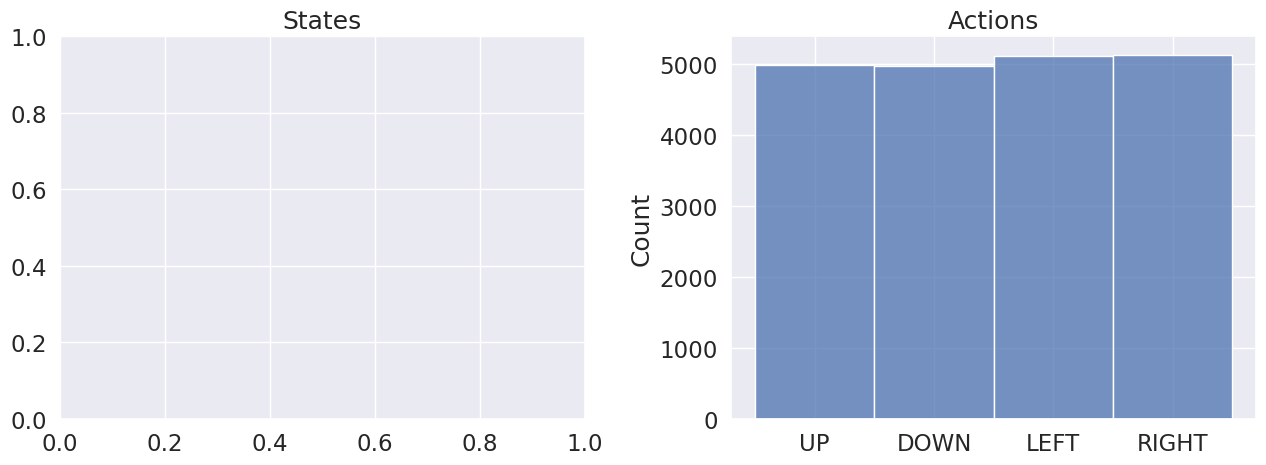

In [27]:
plot_states_actions_distribution(all_states, all_actions)

### Steps & rewards

In [75]:
def plot_steps_and_rewards(df):
    """Plot the steps and rewards from dataframes."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(data=df, x="Episodes", y="Rewards", ax=ax[0])
    ax[0].set(
        ylabel=f"Rewards\naveraged over {p.n_runs} runs" if p.n_runs > 1 else "Rewards"
    )

    sns.lineplot(data=df, x="Episodes", y="Steps", ax=ax[1])
    ax[1].set(
        ylabel=f"Steps number\naveraged over {p.n_runs} runs"
        if p.n_runs > 1
        else "Steps number"
    )

    fig.tight_layout()
    plt.show()

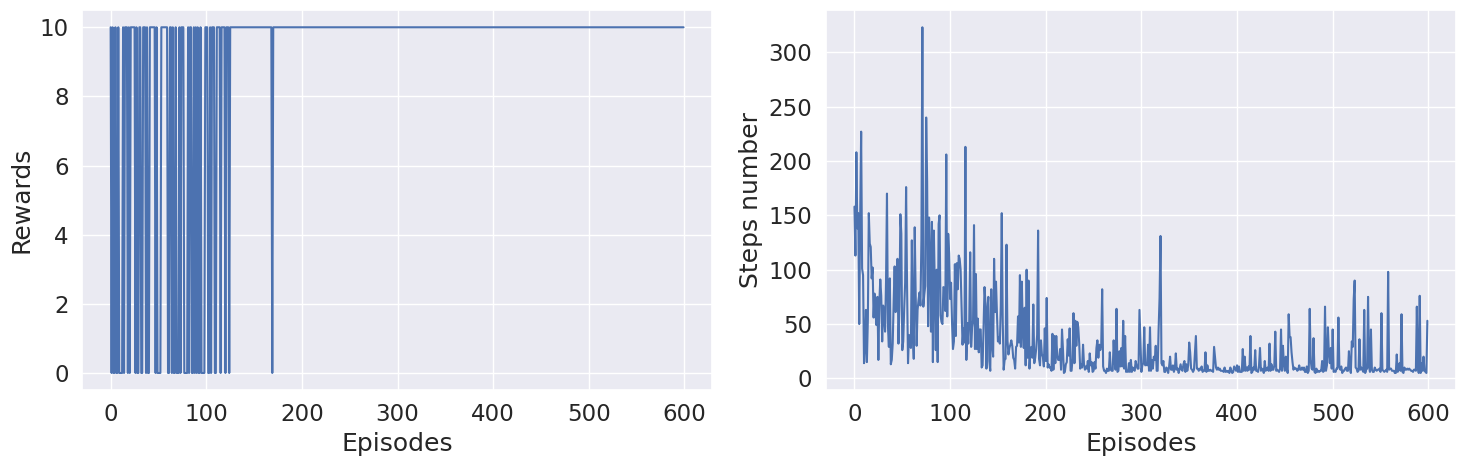

In [76]:
plot_steps_and_rewards(res)

In [95]:
def plot_steps_and_rewards_dist(df):
    """Plot the steps and rewards distributions from dataframes."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.histplot(data=df, x="Rewards", ax=ax[0])
    sns.histplot(data=df, x="Steps", ax=ax[1])
    fig.tight_layout()
    plt.show()

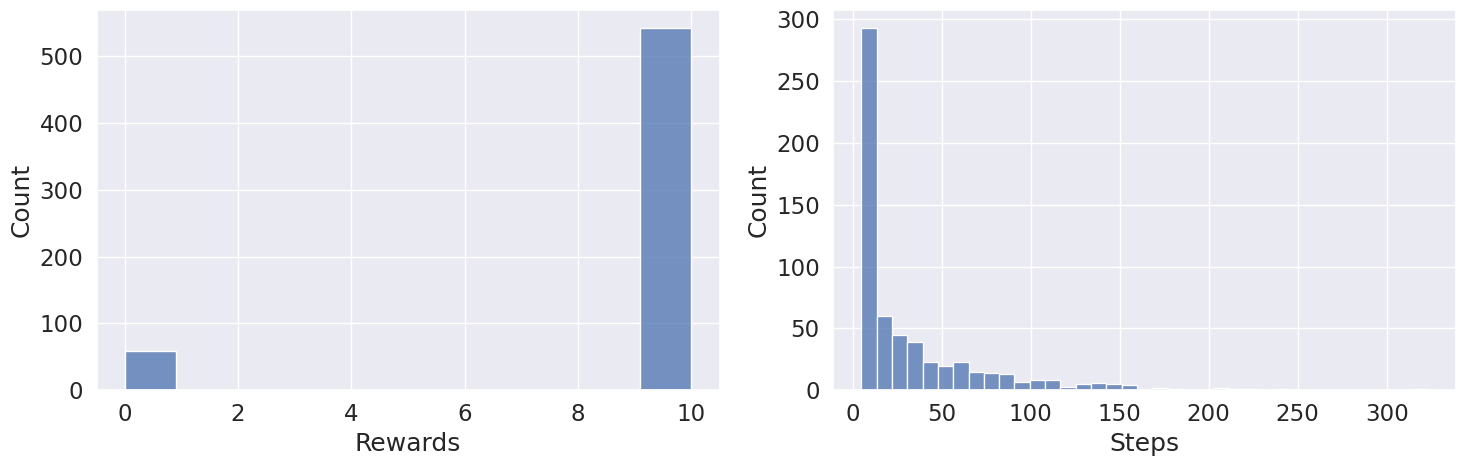

In [96]:
plot_steps_and_rewards_dist(res)

### Loss

In [30]:
window_size = 10
for idx, loss in enumerate(losses):
    current_loss = torch.tensor(loss, device=device)
    losses_rolling_avg = nn.functional.avg_pool1d(
        current_loss.view(1, 1, -1), kernel_size=window_size
    ).squeeze()
    tmp_df = pd.DataFrame(
        data={
            "Run": idx * torch.ones(len(losses_rolling_avg), device=device).int().cpu(),
            "Steps": torch.arange(0, len(losses_rolling_avg), device=device).cpu(),
            "Loss": losses_rolling_avg.cpu(),
        }
    )
    if idx == 0:
        loss_df = tmp_df
    else:
        loss_df = pd.concat((loss_df, tmp_df))
loss_df

,Run,Steps,Loss
0,0,0,0.003277
1,0,1,0.003198
2,0,2,0.000297
3,0,3,0.000272
4,0,4,0.000066
...,...,...,...
2015,0,2015,0.054053
2016,0,2016,0.220050
2017,0,2017,0.008842
2018,0,2018,0.027360


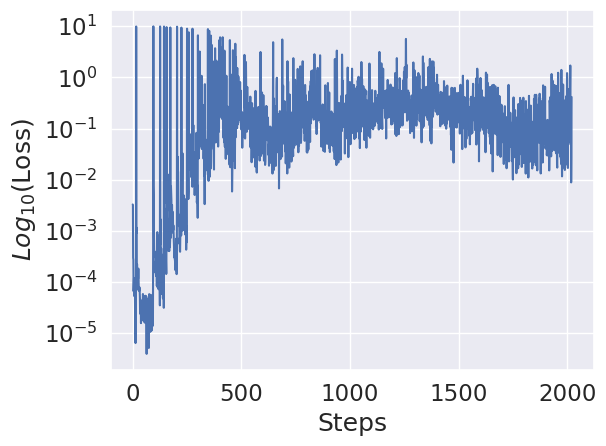

In [31]:
fig, ax = plt.subplots()
sns.lineplot(data=loss_df, x="Steps", y="Loss", ax=ax)
ax.set(
    ylabel=f"$Log_{{10}}(\\text{{Loss}})$\naveraged over {p.n_runs} runs"
    if p.n_runs > 1
    else "$Log_{10}(\\text{Loss})$"
)
ax.set(xlabel="Steps")
ax.set(yscale="log")
fig.tight_layout()
plt.show()

In [32]:
loss_df.iloc[-1].Loss

0.4137454628944397

### Policy learned

In [33]:
with torch.no_grad():
    q_values = torch.nan * torch.empty(
        (len(env.tiles_locations), len(Cues), p.n_actions), device=device
    )
    for tile_i, tile_v in enumerate(env.tiles_locations):
        for cue_i, cue_v in enumerate(Cues):
            state = torch.tensor([tile_v, cue_v.value], device=device).float()
            if env.one_hot_state:
                state = env.to_one_hot(state).float()
            q_values[tile_i, cue_i, :] = net(state).to(device)
q_values.shape

torch.Size([25, 3, 4])

In [34]:
def qtable_directions_map(qtable, rows, cols):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).values.reshape(rows, cols)
    qtable_best_action = qtable.argmax(axis=1).reshape(rows, cols)
    directions = {
        Actions.UP: "↑",
        Actions.DOWN: "↓",
        Actions.LEFT: "←",
        Actions.RIGHT: "→",
    }
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = torch.finfo(torch.float64).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[Actions(val.item())]
    qtable_directions = qtable_directions.reshape(rows, cols)
    return qtable_val_max, qtable_directions

In [35]:
def plot_policies(q_values, labels):
    """Plot the heatmap of the Q-values.

    Also plot the best action's direction with arrows."""

    fig, ax = plt.subplots(1, 3, figsize=(13, 4))
    for idx, cue in enumerate(labels):
        qtable_val_max, qtable_directions = qtable_directions_map(
            qtable=q_values[:, idx, :], rows=env.rows, cols=env.cols
        )
        sns.heatmap(
            qtable_val_max.cpu(),
            annot=qtable_directions,
            fmt="",
            ax=ax.flatten()[idx],
            cmap=sns.color_palette("Blues", as_cmap=True),
            linewidths=0.7,
            linecolor="black",
            xticklabels=[],
            yticklabels=[],
            annot_kws={"fontsize": "xx-large"},
            cbar_kws={"label": "Q-value"},
        ).set(title=labels[cue])
        for _, spine in ax.flatten()[idx].spines.items():
            spine.set_visible(True)
            spine.set_linewidth(0.7)
            spine.set_color("black")

        # Annotate the ports names
        bbox = {
            "facecolor": "black",
            "edgecolor": "none",
            "boxstyle": "round",
            "alpha": 0.1,
        }
        ax.flatten()[idx].text(
            x=4.7,
            y=0.3,
            s="N",
            bbox=bbox,
            color="white",
        )
        ax.flatten()[idx].text(
            x=0.05,
            y=4.9,
            s="S",
            bbox=bbox,
            color="white",
        )
        ax.flatten()[idx].text(
            x=4.7,
            y=4.9,
            s="E",
            bbox=bbox,
            color="white",
        )
        ax.flatten()[idx].text(
            x=0.05,
            y=0.3,
            s="W",
            bbox=bbox,
            color="white",
        )

    # Make background transparent
    fig.patch.set_alpha(0)
    fig.patch.set_facecolor("white")
    fig.tight_layout()
    plt.show()

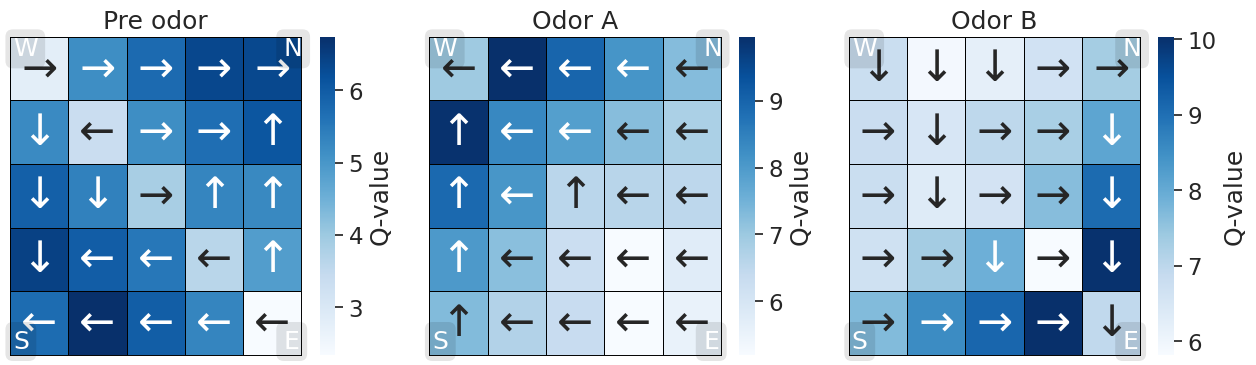

In [36]:
plot_policies(q_values=q_values, labels=CONTEXTS_LABELS)

### Weights & gradients metrics

In [37]:
weights, biases = collect_weights_biases(net=net)

In [38]:
def params_df_flat(weights):
    for idx, val in enumerate(weights):
        tmp_df = pd.DataFrame(
            data={
                "Val": val.detach().cpu().flatten(),
                "Layer": idx,
            }
        )
        if idx == 0:
            df = tmp_df
        else:
            df = pd.concat((df, tmp_df))
    return df

In [39]:
weights_val_df = params_df_flat(weights["val"])
weights_val_df

,Val,Layer
0,-0.091548,0
1,0.144196,0
2,0.068627,0
3,-0.043019,0
4,0.085141,0
...,...,...
331,0.050788,3
332,0.008461,3
333,-0.031884,3
334,-0.048268,3


In [40]:
weights_val_df.describe()

,Val,Layer
count,16800.000000,16800.000000
mean,-0.000408,1.320000
std,0.099427,0.733234
min,-0.848193,0.000000
25%,-0.059619,1.000000
50%,-0.004915,1.000000
75%,0.051375,2.000000
max,0.822803,3.000000


In [41]:
biases_val_df = params_df_flat(biases["val"])
biases_val_df

,Val,Layer
0,0.113062,0
1,-0.018940,0
2,-0.019591,0
3,0.067627,0
4,-0.055699,0
...,...,...
83,0.012676,2
0,0.274577,3
1,0.156089,3
2,0.244919,3


In [42]:
biases_val_df.describe()

,Val,Layer
count,256.000000,256.000000
mean,0.025484,1.031250
std,0.133307,0.848875
min,-0.239361,0.000000
25%,-0.076361,0.000000
50%,-0.006145,1.000000
75%,0.109542,2.000000
max,0.402811,3.000000


In [43]:
weights_grad_df = params_df_flat(weights["grad"])
weights_grad_df

,Val,Layer
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
...,...,...
331,0.0,3
332,0.0,3
333,0.0,3
334,0.0,3


In [44]:
weights_grad_df.describe()

,Val,Layer
count,16800.000000,16800.000000
mean,0.000426,1.320000
std,0.006358,0.733234
min,-0.193906,0.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,2.000000
max,0.215419,3.000000


In [45]:
biases_grad_df = params_df_flat(biases["grad"])
biases_grad_df

,Val,Layer
0,0.000000,0
1,0.000000,0
2,0.000000,0
3,0.215419,0
4,0.000000,0
...,...,...
83,0.000000,2
0,0.165090,3
1,0.000000,3
2,0.000000,3


In [46]:
biases_grad_df.describe()

,Val,Layer
count,256.000000,256.000000
mean,0.006834,1.031250
std,0.033223,0.848875
min,-0.193906,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,0.000000,2.000000
max,0.215419,3.000000


In [47]:
def check_grad_stats(grad_df):
    grad_stats = torch.tensor(
        [
            grad_df.Val.mean(),
            grad_df.Val.std(),
            grad_df.Val.min(),
            grad_df.Val.max(),
        ],
        device=device,
    )
    assert not torch.equal(
        torch.zeros_like(grad_stats),
        grad_stats,
    ), "Gradients are zero"

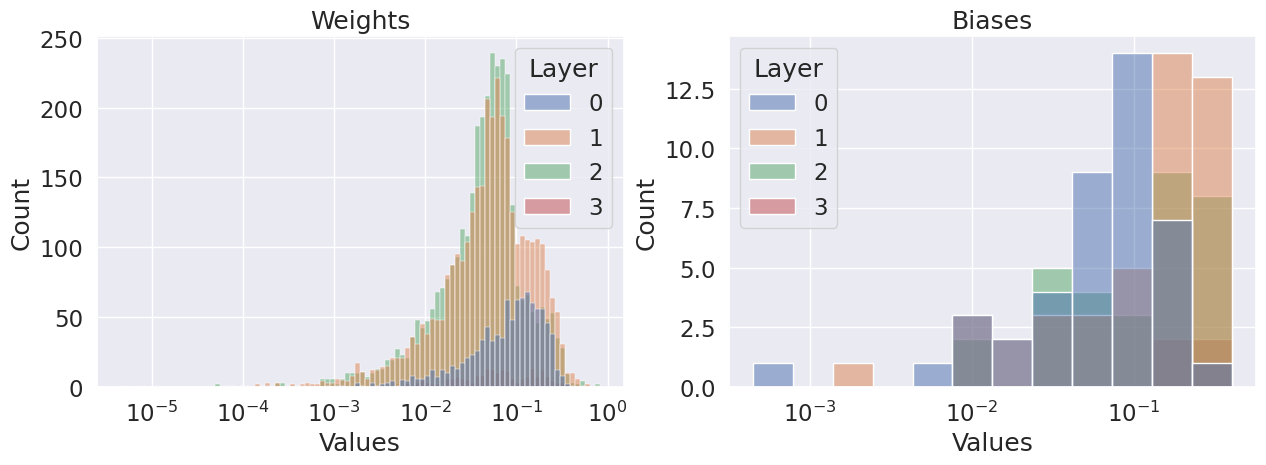

In [48]:
plotting.plot_weights_biases_distributions(
    weights_val_df, biases_val_df, label="Values"
)

In [49]:
check_grad_stats(weights_grad_df)

In [50]:
check_grad_stats(biases_grad_df)

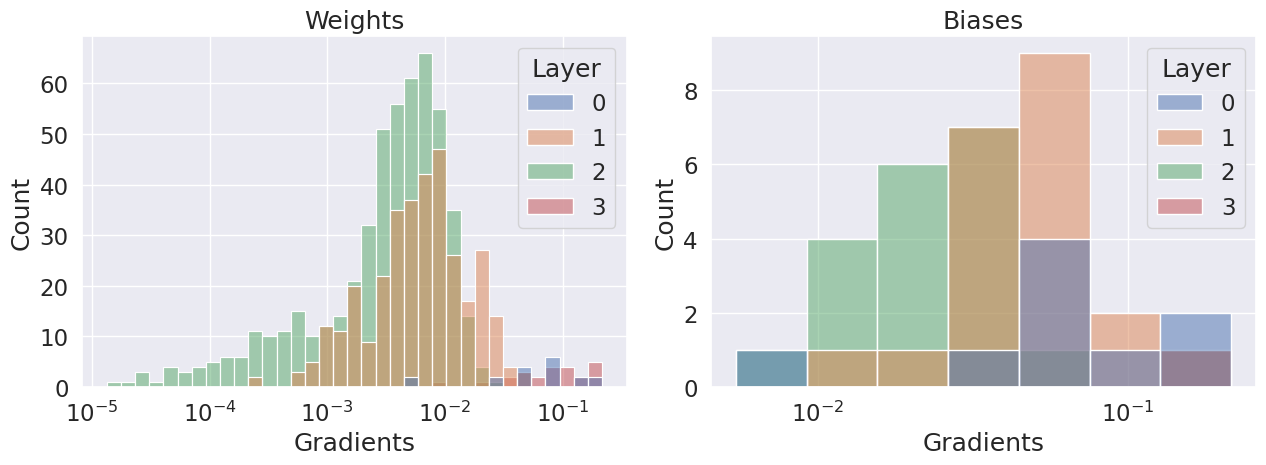

In [51]:
plotting.plot_weights_biases_distributions(
    weights_grad_df, biases_grad_df, label="Gradients"
)

In [52]:
weights_val_stats

,Std,Avg,Layer
Index,,,
0,0.108682,-8.418095e-04,0
1,0.062861,-1.202301e-03,1
2,0.062927,-1.193203e-03,2
3,0.060576,2.035130e-03,3
4,0.000005,1.716383e-07,0
...,...,...,...
4791,0.315423,-7.303022e-02,3
4792,0.124422,-1.709000e-02,0
4793,0.103595,3.064250e-04,1


In [53]:
biases_val_stats

,Std,Avg,Layer
Index,,,
0,0.102390,0.009558,0
1,0.058936,-0.005056,1
2,0.060861,-0.018044,2
3,0.052493,0.039803,3
4,0.105150,0.008852,0
...,...,...,...
2395,0.058331,0.212279,3
2396,0.112565,-0.008544,0
2397,0.139494,0.054263,1


In [54]:
weights_grad_stats

,Std,Avg,Layer
Index,,,
0,0.108682,-8.418095e-04,0
1,0.062861,-1.202301e-03,1
2,0.062927,-1.193203e-03,2
3,0.060576,2.035130e-03,3
4,0.000005,1.716383e-07,0
...,...,...,...
4795,0.094082,3.658029e-02,3
4796,0.011540,1.688882e-04,0
4797,0.002701,3.569986e-04,1


In [55]:
biases_grad_stats

,Std,Avg,Layer
Index,,,
0,0.000017,0.000002,0
1,0.000040,0.000012,1
2,0.000100,0.000036,2
3,0.001275,0.000637,3
4,0.000349,0.000160,0
...,...,...,...
2395,0.318821,-0.159411,3
2396,0.043369,0.002364,0
2397,0.030711,0.012009,1


In [56]:
def plot_weights_biases_stats(weights_stats, biases_stats, label=None):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(13, 8))

    if label:
        ax[0, 0].set_title("Weights " + label)
    else:
        ax[0, 0].set_title("Weights")
    ax[0, 0].set_xlabel("Episodes")
    palette = sns.color_palette()[0 : len(weights_stats.Layer.unique())]
    sns.lineplot(
        data=weights_stats,
        x="Index",
        y="Std",
        hue="Layer",
        palette=palette,
        ax=ax[0, 0],
    )
    ax[0, 0].set(yscale="log")

    if label:
        ax[0, 1].set_title("Weights " + label)
    else:
        ax[0, 1].set_title("Weights")
    ax[0, 1].set_xlabel("Episodes")
    palette = sns.color_palette()[0 : len(weights_stats.Layer.unique())]
    sns.lineplot(
        data=weights_stats,
        x="Index",
        y="Avg",
        hue="Layer",
        palette=palette,
        ax=ax[0, 1],
    )
    ax[0, 1].set(yscale="log")

    if label:
        ax[1, 0].set_title("Biases " + label)
    else:
        ax[1, 0].set_title("Biases")
    ax[1, 0].set_xlabel("Episodes")
    palette = sns.color_palette()[0 : len(biases_stats.Layer.unique())]
    sns.lineplot(
        data=biases_stats,
        x="Index",
        y="Std",
        hue="Layer",
        palette=palette,
        ax=ax[1, 0],
    )
    ax[1, 0].set(yscale="log")

    if label:
        ax[1, 1].set_title("Biases " + label)
    else:
        ax[1, 1].set_title("Biases")
    ax[1, 1].set_xlabel("Episodes")
    palette = sns.color_palette()[0 : len(biases_stats.Layer.unique())]
    sns.lineplot(
        data=biases_stats,
        x="Index",
        y="Avg",
        hue="Layer",
        palette=palette,
        ax=ax[1, 1],
    )
    ax[1, 1].set(yscale="log")

    fig.tight_layout()
    plt.show()

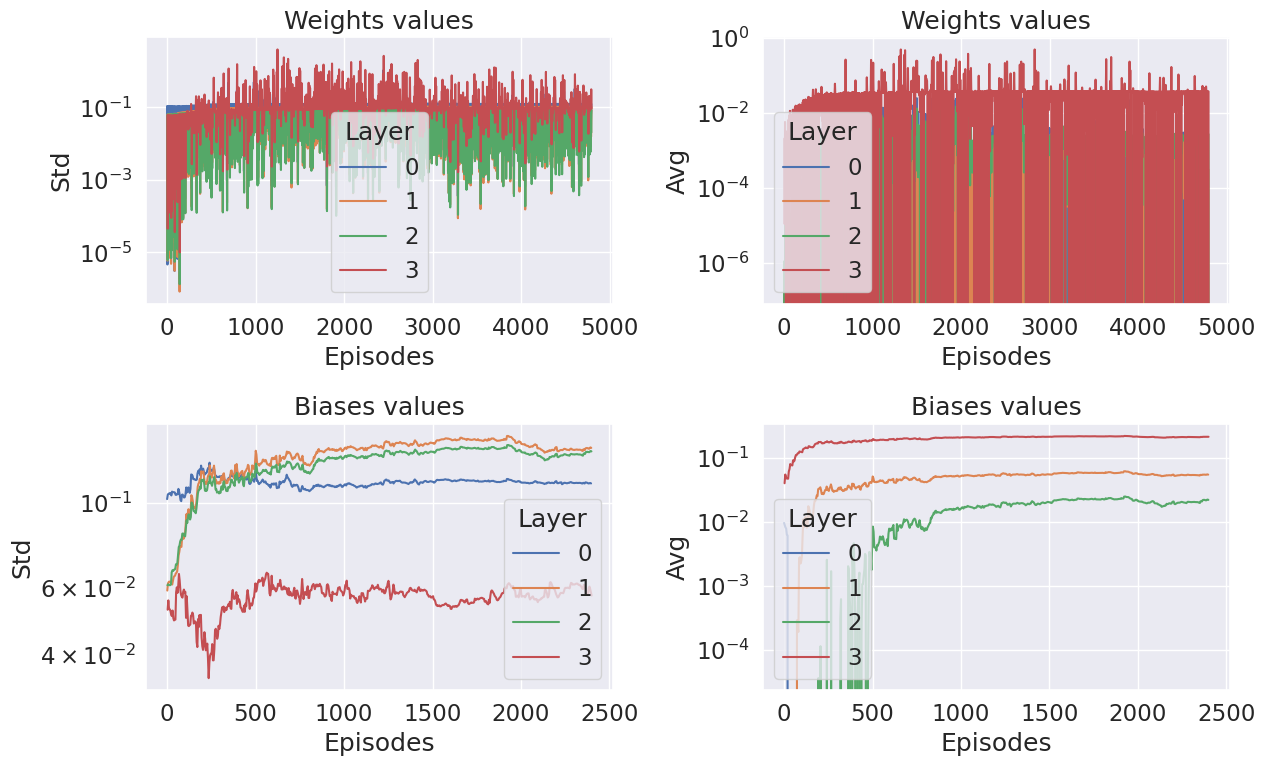

In [57]:
plot_weights_biases_stats(weights_val_stats, biases_val_stats, label="values")

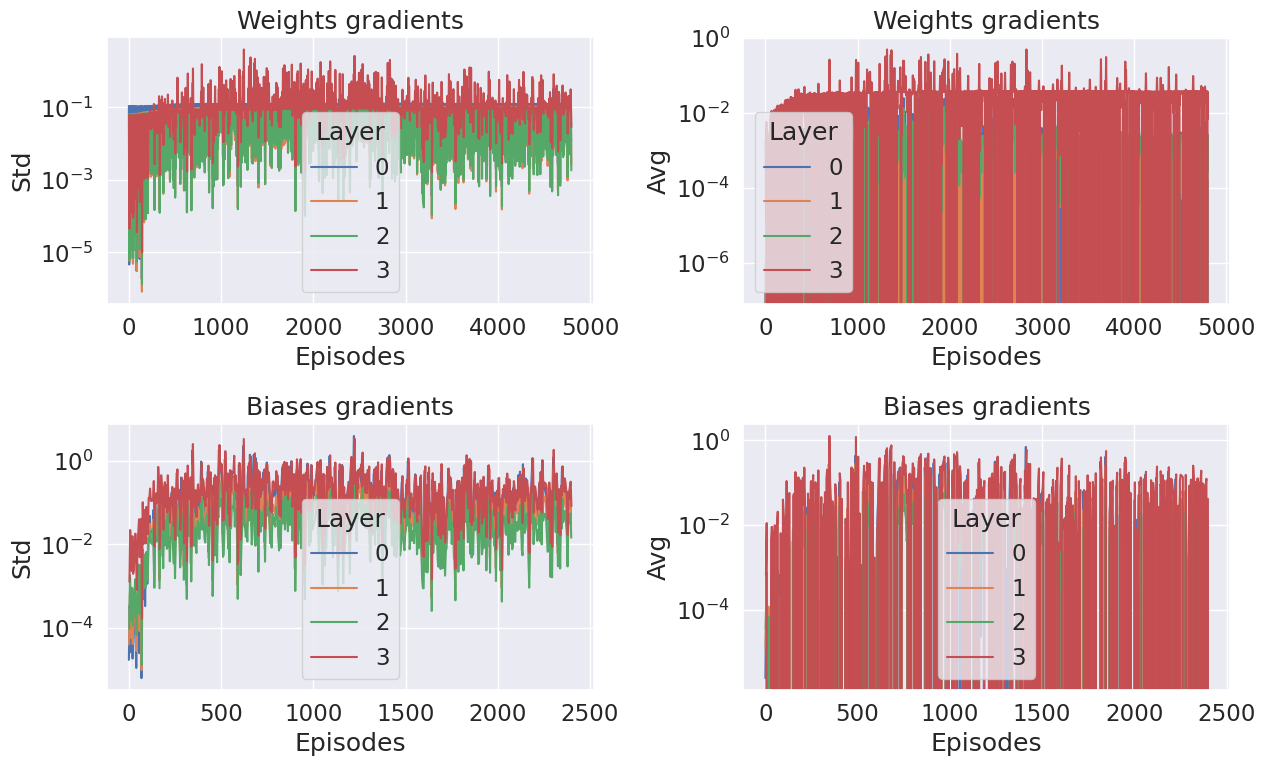

In [58]:
plot_weights_biases_stats(weights_grad_stats, biases_grad_stats, label="gradients")